# Detecção de logos e assinaturas

In [45]:
# Importação das bibliotecas
import xml.etree.ElementTree as ET
import os, sys, json, shutil, zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
import locale
import cv2
from glob import glob
from IPython.display import display
from google.colab import userdata, drive
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [24]:
# Caminho completo do diretório .kaggle
kaggle_folder = os.path.expanduser('~/.kaggle')

# Cria o diretório se não existir
os.makedirs(kaggle_folder, exist_ok=True)

# Caminho completo do arquivo JSON de autenticação
kaggle_auth_file = os.path.join(kaggle_folder, 'kaggle.json')

# Cria o arquivo JSON de autenticação
with open(kaggle_auth_file, 'w') as jsonFile:
    json.dump({
        'username': userdata.get('kaggle_usr'),
        'key': userdata.get('kaggle_key')
    }, jsonFile)

# Define as permissões do arquivo
os.chmod(kaggle_auth_file, 0o600)

print('Arquivo JSON de autenticação criado com sucesso em:', kaggle_auth_file)

Arquivo JSON de autenticação criado com sucesso em: /root/.kaggle/kaggle.json


In [25]:
# Instalar o pacote kaggle
!pip install kaggle

In [26]:
# Excluir diretório existente
if os.path.exists('/content/datasets/'):
    shutil.rmtree('/content/datasets/')

# Cria o diretório se não existir
os.makedirs('/content/datasets/raw/', exist_ok=True)

# Fazer download do dataset
!kaggle datasets download -d kaiquanmah/tobacco800-with-ground-truth --path /content/datasets/raw --force

Dataset URL: https://www.kaggle.com/datasets/kaiquanmah/tobacco800-with-ground-truth
License(s): unknown
 95% 31.0M/32.8M [00:02<00:00, 21.2MB/s]
100% 32.8M/32.8M [00:02<00:00, 14.0MB/s]


In [27]:
!unzip /content/datasets/raw/tobacco800-with-ground-truth.zip -d /content/datasets/raw/tobacco800-with-ground-truth/

Archive:  /content/datasets/raw/tobacco800-with-ground-truth.zip
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/Overview of Tobacco800 Groundtruth_v2.0.txt  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aah97e00-page02_1.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aah97e00-page02_2.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aam09c00.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aao54e00_1.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/a

In [28]:
# Define os caminhos para acessar o dataset e os arquivos associados à fonte de dados.
source_dataset_path = '/content/datasets/raw/tobacco800-with-ground-truth'
source_images_path = f'{source_dataset_path}/Tobacco800_SinglePage/Tobacco800_SinglePage/SinglePageTIF'
source_annotation_files_path = f'{source_dataset_path}/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0'

# Lista em ordem alfabética todos os arquivos XML dentro do diretório especificado
annotation_files = sorted(glob(f'{source_annotation_files_path}/*.xml'))

# Inicializa uma lista para armazenar informações extraídas dos arquivos XML
extracted_data = []

# Coletar todas as categorias de todos os nós para treinamento do LabelEncoder
all_categories = []
for file_path in annotation_files:
    root_element = ET.parse(file_path).getroot()
    for node in root_element[0][0]:
        all_categories.append(node.attrib.get('gedi_type'))

# Treinar o LabelEncoder com todas as categorias coletadas
label_encoder = LabelEncoder()
label_encoder.fit(all_categories)

# Processar cada arquivo XML
for file_path in annotation_files:
    root_element = ET.parse(file_path).getroot()
    file_name = root_element[0].attrib.get('src')
    page_height = root_element[0][0].attrib.get('height')
    page_width = root_element[0][0].attrib.get('width')

    # Extrair informações de cada nó na página
    for node in root_element[0][0]:
        id = node.attrib.get('id')
        gedi_type = node.attrib.get('gedi_type')
        labels = label_encoder.transform([gedi_type])

        x, y = node.attrib.get('col'), node.attrib.get('row')
        w, h = node.attrib.get('width'), node.attrib.get('height')

        if gedi_type == 'DLSignature':
            author = node.attrib.get('AuthorID')
            is_overlapped = node.attrib.get('Overlapped')
        else:
            author, is_overlapped = ('NA', 'NA')

        # Construir linha com os dados essenciais
        row = [file_name, gedi_type, labels, x, y, w, h, page_width, page_height, author, is_overlapped, id]
        extracted_data.append(row)

# Criar um DataFrame com os dados extraídos
xml_extracted_data = pd.DataFrame(extracted_data, columns=[
    'file_name', 'gedi_type', 'labels', 'x', 'y', 'w', 'h',
    'page_width', 'page_height', 'author', 'is_overlapped', 'id'
])
xml_extracted_data.head(10)

,file_name,gedi_type,labels,x,y,w,h,page_width,page_height,author,is_overlapped,id
0,aah97e00-page02_1.tif,DLLogo,[0],1074,18,374,219,2560,3296,NA,NA,None
1,aah97e00-page02_2.tif,DLSignature,[1],1409,793,659,361,2560,3296,"Boder, J.B.",Yes,None
2,aam09c00.tif,DLSignature,[1],821,1422,757,183,1728,2292,"Koplow, M.G.",Yes,None
3,aao54e00_2.tif,DLSignature,[1],1514,708,627,206,2560,3296,"Landry, J.T.",Yes,None
4,abm69c00.tif,DLSignature,[1],667,1279,617,110,1728,2292,"Feldman, J.D.",Yes,None
5,acr64d00.tif,DLSignature,[1],886,1801,463,181,1728,2292,"Boffa, J.R.",Yes,None
6,adh36e00-page2_1.tif,DLLogo,[0],1181,18,359,219,2560,3245,NA,NA,None
7,adh36e00-page2_2.tif,DLSignature,[1],1232,2399,896,431,2560,3246,"Krivisky, B.M.",Yes,None
8,adh36e00_1.tif,DLLogo,[0],1187,18,347,219,2560,3245,NA,NA,None
9,adh36e00_2.tif,DLSignature,[1],1239,2403,889,434,2560,3246,"Krivisky, B.M.",Yes,None


In [29]:
dataset_name = 'tobacco800'
target_dataset_path = f'/content/datasets/{dataset_name}'
target_resized_images_path = f'{target_dataset_path}/images/resized'

# Excluir diretório existente
if os.path.exists(target_resized_images_path):
    shutil.rmtree(target_resized_images_path)

# Cria o diretório se não existir
os.makedirs(target_resized_images_path, exist_ok=True)

In [30]:
# Redimensionando as imagens para reduzir o tempo de treinamento
def resizing_extracted_data(data):
    resized_data = []

    for file, labels, x, y, w, h in zip(data.file_name, data.labels, map(int, data.x), map(int, data.y), map(int, data.w), map(int, data.h)):
        image_path = f'{source_images_path}/{file}'
        image = cv2.imread(image_path, 1)

        page_height, page_width = image.shape[:2]
        max_height = 640
        max_width = 480

        resize_factor = min(max_height / page_height, max_width / page_width)

        if resize_factor < 1:
            image = cv2.resize(image, None, fx=resize_factor, fy=resize_factor, interpolation=cv2.INTER_AREA)

        resized_file_name = f'{file[:-4]}.jpg'
        cv2.imwrite(f'{target_resized_images_path}/{resized_file_name}', image)

        # Salva novas dimensões da página
        resized_page_width, resized_page_height = int(page_width * resize_factor), int(page_height * resize_factor)

        # Calcula novas coordenadas x, y, w, h após redimensionamento
        resized_x, resized_y, resized_w, resized_h = int(x * resize_factor), int(y * resize_factor), int(w * resize_factor), int(h * resize_factor)

        row = [resized_file_name, labels, resized_x, resized_y, resized_w, resized_h, resized_page_width, resized_page_height]
        resized_data.append(row)
    return resized_data

resized_data = resizing_extracted_data(xml_extracted_data)

resized_data = pd.DataFrame(resized_data, columns=['file_name', 'labels', 'x', 'y', 'w', 'h', 'page_width', 'page_height'])
resized_data.head(10)

,file_name,labels,x,y,w,h,page_width,page_height
0,aah97e00-page02_1.jpg,[0],201,3,70,41,480,618
1,aah97e00-page02_2.jpg,[1],264,148,123,67,480,618
2,aam09c00.jpg,[1],228,395,210,50,480,636
3,aao54e00_2.jpg,[1],283,132,117,38,480,618
4,abm69c00.jpg,[1],185,355,171,30,480,636
5,acr64d00.jpg,[1],246,500,128,50,480,636
6,adh36e00-page2_1.jpg,[0],221,3,67,41,480,608
7,adh36e00-page2_2.jpg,[1],231,449,168,80,480,608
8,adh36e00_1.jpg,[0],222,3,65,41,480,608
9,adh36e00_2.jpg,[1],232,450,166,81,480,608


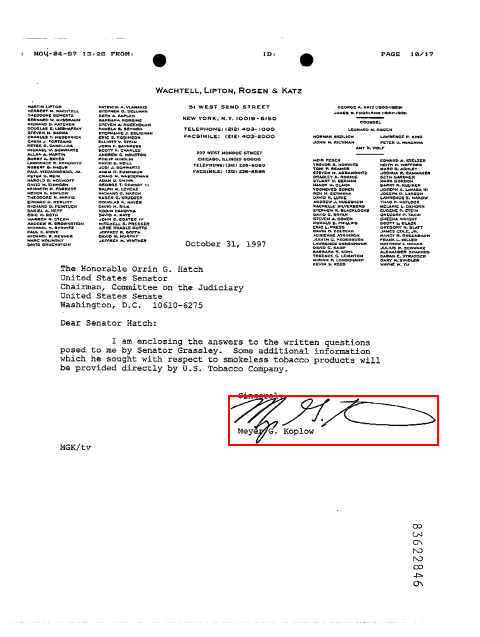

In [31]:
# Teste do redimensionamento das imagens e suas respectivas anotações.
def draw_boxes_on_image(data):
    file, x, y, w, h = data.file_name, data.x, data.y, data.w, data.h
    image = Image.open(f'{target_resized_images_path}/{file}')
    draw = ImageDraw.Draw(image)
    draw.rectangle([(x, y), (x + w, y + h)], outline='red', width=2)
    display(image)
draw_boxes_on_image(resized_data.iloc[2])

In [32]:
train_data, valid_data = train_test_split(resized_data, test_size=0.1, random_state=13, shuffle=True)
print(train_data.shape, valid_data.shape)

(1207, 8) (135, 8)


In [33]:
target_val_images_path = f'{target_dataset_path}/images/val'
target_val_labels_path = f'{target_dataset_path}/labels/val'
target_train_images_path = f'{target_dataset_path}/images/train'
target_train_labels_path = f'{target_dataset_path}/labels/train'

# Excluir diretório existente
if os.path.exists(target_val_images_path):
    shutil.rmtree(target_val_images_path)

if os.path.exists(target_val_labels_path):
    shutil.rmtree(target_val_labels_path)

if os.path.exists(target_train_images_path):
    shutil.rmtree(target_train_images_path)

if os.path.exists(target_train_labels_path):
    shutil.rmtree(target_train_labels_path)

# Cria o diretório se não existir
os.makedirs(target_val_images_path, exist_ok=True)
os.makedirs(target_val_labels_path, exist_ok=True)
os.makedirs(target_train_images_path, exist_ok=True)
os.makedirs(target_train_labels_path, exist_ok=True)

In [34]:
def yolo_format(data):
    x, y, w, h, page_width, page_height = data.x, data.y, data.w, data.h, data.page_width, data.page_height

    x_center = int(x + (w / 2))
    y_center = int(y + (h / 2))

    normalized_x = x_center / page_width
    normalized_y = y_center / page_height

    normalized_w = w / page_width
    normalized_h = h / page_height

    return [normalized_x, normalized_y, normalized_w, normalized_h]

def segregate_data(data, source_images_path, target_images_path, target_labels_path):
    # Obter nomes de arquivos únicos
    file_names = set(data['file_name'])

    for file_name in file_names:
        yolo_list = []

        # Filtrar linhas para o arquivo atual
        file_data = data[data['file_name'] == file_name]

        for _, row in file_data.iterrows():
            yolo_list.append([row.labels[0], *yolo_format(row)])

        # Converter yolo_list em array NumPy
        yolo_list = np.array(yolo_list)

        # Salvar os dados em arquivos TXT
        txt_file_name = os.path.join(target_labels_path, f'{file_name.split(".")[0]}.txt')
        np.savetxt(txt_file_name, yolo_list, fmt=['%d', '%f', '%f', '%f', '%f'])

        # Copiar as imagens de origem para o destino
        source_images = os.path.join(source_images_path, file_name)
        target_images = os.path.join(target_images_path, file_name)
        shutil.copyfile(source_images, target_images)

segregate_data(train_data, target_resized_images_path, target_train_images_path, target_train_labels_path)
segregate_data(valid_data, target_resized_images_path, target_val_images_path, target_val_labels_path)

# Número de arquivos de imagem e rótulos nos diretórios de treinamento e validação
print('Número de imagens de treinamento:', len(os.listdir(target_train_images_path)))
print('Número de rótulos de treinamento:', len(os.listdir(target_train_labels_path)))
print('Número de imagens de validação:', len(os.listdir(target_val_images_path)))
print('Número de rótulos de validação:', len(os.listdir(target_val_labels_path)))

Número de imagens de treinamento: 807
Número de rótulos de treinamento: 807
Número de imagens de validação: 129
Número de rótulos de validação: 129


In [35]:
# Remover arquivo `.ipynb_checkpoints` criado automaticamente em diretórios e subdiretórios
!find /content/ -type f -name '.ipynb_checkpoints' -exec rm {} +

In [36]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Não conectado a uma GPU.')
else:
  print(gpu_info)

Wed May  1 21:32:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   34C    P8              16W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [42]:
# Integração com a API do GitHub
%pip install PyGithub
from github import Github

# Criando uma instância do PyGithub com um token de acesso pessoal
github_access = Github(userdata.get('github_token'))

# Obtendo o repositório
github_repo = github_access.get_repo('ronaldo-fs/signature-detection')

# Obtendo o conteúdo do arquivo
contents = github_repo.get_contents('src/tobacco800.yaml', ref='fix/source-files')

# Define o caminho completo do arquivo
tobacco800_config_file = os.path.join(target_dataset_path, '..', f'{dataset_name}.yaml')

# Escrevendo o conteúdo em um arquivo local
with open(tobacco800_config_file, 'wb') as file:
    file.write(contents.decoded_content)

print('Arquivo salvo em:', tobacco800_config_file)

Arquivo salvo em: /content/datasets/tobacco800.yaml


In [38]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (16 CPUs, 62.8 GB RAM, 29.0/201.2 GB disk)


In [57]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')
model = YOLO('yolov8n.yaml').load('yolov8n.pt')

results = model.train(data='/content/datasets/tobacco800.yaml', task='detect', epochs=300, imgsz=640, patience=100)

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/datasets/tobacco800.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

train: Scanning /content/datasets/tobacco800/labels/train.cache... 807 images, 0 backgrounds, 0 corrupt: 100%|██████████| 807/807 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/tobacco800/labels/val.cache... 129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 129/129 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300       2.2G       1.56      2.924      1.186         16        640: 100%|██████████| 51/51 [00:06<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


                   all        129        135     0.0034      0.959      0.211       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.12G      1.314      1.837       1.07         21        640: 100%|██████████| 51/51 [00:05<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


                   all        129        135      0.496      0.667      0.507      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.11G      1.277      1.605      1.091         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]

                   all        129        135      0.474      0.648      0.486      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.11G      1.247      1.433      1.068         21        640: 100%|██████████| 51/51 [00:05<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.88it/s]

                   all        129        135       0.53      0.642      0.489      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.11G      1.234      1.324      1.064         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.01it/s]

                   all        129        135      0.537      0.754      0.575      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.11G      1.189       1.22      1.053         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.76it/s]

                   all        129        135      0.485      0.705       0.51      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.11G      1.154      1.126      1.035         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]

                   all        129        135      0.556      0.682      0.598      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.11G      1.141      1.073      1.018         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.96it/s]

                   all        129        135      0.526      0.919      0.573      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.11G      1.122     0.9964      1.014         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]

                   all        129        135       0.47      0.822      0.573      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.11G      1.132      0.974      1.017         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.10it/s]

                   all        129        135      0.506      0.811      0.574      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.11G      1.106     0.9664      1.018         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.04it/s]

                   all        129        135       0.51      0.908      0.613      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.11G      1.054     0.9065     0.9873         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]

                   all        129        135      0.493      0.834      0.547      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.11G       1.05     0.8768     0.9904         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.06it/s]

                   all        129        135      0.531      0.865      0.576      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.11G      1.025     0.8569     0.9838         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.10it/s]

                   all        129        135      0.511      0.906      0.567      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.11G      1.094      0.872     0.9937         11        640: 100%|██████████| 51/51 [00:04<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.77it/s]

                   all        129        135      0.548      0.834      0.593      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.11G      1.039     0.8597     0.9871         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.95it/s]

                   all        129        135        0.5      0.901      0.624      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.11G      1.018     0.8147     0.9804         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.24it/s]

                   all        129        135      0.515      0.891      0.606      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.11G      1.034     0.8341     0.9739         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]

                   all        129        135      0.521       0.87      0.599       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.11G      1.012     0.7984     0.9744         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.02it/s]

                   all        129        135      0.547      0.862      0.609      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.11G     0.9973     0.7946     0.9669         26        640: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]

                   all        129        135      0.538      0.794      0.569      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.11G      1.008     0.8098     0.9696         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.27it/s]

                   all        129        135      0.497      0.861       0.55      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.11G     0.9954     0.7933     0.9672         24        640: 100%|██████████| 51/51 [00:05<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.86it/s]

                   all        129        135      0.521      0.941      0.577      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.11G     0.9999     0.7822     0.9706         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.493      0.741        0.5      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.11G      1.022     0.7922     0.9804         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.99it/s]

                   all        129        135       0.45      0.562       0.39      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.11G     0.9636     0.7561     0.9561         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]

                   all        129        135      0.492      0.771      0.498      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.11G     0.9842     0.7508     0.9696         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.78it/s]

                   all        129        135      0.537      0.879      0.564      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.11G     0.9743     0.7493     0.9612         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]

                   all        129        135      0.516      0.884      0.562      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.11G     0.9596     0.7406     0.9524         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.581      0.851      0.589       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.11G     0.9604     0.7322     0.9643         11        640: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]

                   all        129        135       0.52      0.904      0.578      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.11G     0.9455     0.7149     0.9526         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]

                   all        129        135      0.528      0.911      0.597      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.11G     0.9101     0.6891     0.9425         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.534      0.818      0.578      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.11G     0.9317     0.6993     0.9472         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.16it/s]

                   all        129        135      0.535      0.908      0.594      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.11G     0.9511     0.7052     0.9522         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.92it/s]

                   all        129        135      0.524      0.886       0.56       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.11G      0.936       0.71     0.9424         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.10it/s]

                   all        129        135      0.519      0.882      0.593      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.11G     0.9206     0.6999       0.94         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]

                   all        129        135      0.504      0.867      0.558      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.11G     0.9544     0.7314     0.9578         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.01it/s]

                   all        129        135      0.523      0.819      0.604      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.11G     0.9465      0.702     0.9548         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.25it/s]

                   all        129        135       0.54      0.846      0.597       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.11G     0.9359     0.6919     0.9451         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.92it/s]

                   all        129        135      0.526      0.898      0.572      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.11G     0.9203     0.6735     0.9378          8        640: 100%|██████████| 51/51 [00:04<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.35it/s]

                   all        129        135        0.5      0.865      0.596      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.11G     0.8976     0.6737     0.9409          9        640: 100%|██████████| 51/51 [00:04<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.95it/s]

                   all        129        135      0.509      0.841      0.564      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.11G     0.9272     0.6717     0.9459         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]

                   all        129        135      0.474      0.904      0.558      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.11G     0.9215     0.6748     0.9408         26        640: 100%|██████████| 51/51 [00:04<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]

                   all        129        135      0.508      0.855      0.555       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.11G     0.9153     0.6792     0.9417         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]

                   all        129        135      0.524      0.916      0.576      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.11G     0.9102     0.6786     0.9369         10        640: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.98it/s]

                   all        129        135      0.518      0.883      0.583      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.11G     0.9146     0.6839     0.9466         26        640: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.553      0.811      0.605      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.11G     0.9277     0.6653     0.9492         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.74it/s]

                   all        129        135      0.546      0.878      0.653      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.11G     0.8953     0.6403     0.9333         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]

                   all        129        135      0.531      0.918      0.612      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.11G     0.9306     0.6641     0.9521         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]

                   all        129        135      0.507      0.901      0.611      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.11G     0.8992     0.6542     0.9346         11        640: 100%|██████████| 51/51 [00:04<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.01it/s]

                   all        129        135      0.533      0.834      0.585      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.11G     0.9082     0.6535     0.9307         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.68it/s]

                   all        129        135      0.512      0.897      0.604      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.11G      0.896     0.6443     0.9267         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.06it/s]

                   all        129        135      0.516      0.865      0.594      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.11G     0.8459     0.6164     0.9246         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]

                   all        129        135      0.524      0.878      0.567      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.11G     0.8588      0.628       0.93         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.24it/s]

                   all        129        135      0.505      0.916      0.555      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.11G     0.8718     0.6154     0.9309         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.507      0.911      0.602      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.11G     0.8673     0.6241     0.9241         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.78it/s]

                   all        129        135      0.488       0.85       0.58      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.11G     0.8697     0.6079      0.924         25        640: 100%|██████████| 51/51 [00:04<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.73it/s]

                   all        129        135      0.533      0.882      0.543      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.11G     0.8557     0.5991     0.9268         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.85it/s]

                   all        129        135      0.515      0.863      0.552      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.11G     0.8563     0.6111     0.9269         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.91it/s]

                   all        129        135      0.533      0.885      0.538      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.11G     0.8548     0.6367     0.9237         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]

                   all        129        135      0.529      0.911      0.583       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.11G     0.8661     0.6235     0.9269         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.94it/s]

                   all        129        135      0.503      0.876      0.549      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.11G     0.8864     0.6358     0.9289         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]

                   all        129        135      0.528      0.908      0.538       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.11G     0.8677     0.6052     0.9252         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.93it/s]

                   all        129        135      0.535      0.924      0.594      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.11G     0.8794      0.618     0.9273         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.33it/s]

                   all        129        135      0.523      0.844      0.573      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.11G     0.8585     0.6184     0.9235         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.96it/s]

                   all        129        135       0.53      0.835      0.604      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.11G     0.8445     0.6069     0.9153         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.95it/s]

                   all        129        135       0.53       0.87      0.572      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.11G     0.8275     0.5959     0.9112         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.26it/s]

                   all        129        135       0.55       0.85       0.59      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.11G     0.8463     0.6253     0.9181         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]

                   all        129        135      0.534      0.886      0.611      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.11G     0.8575     0.6016     0.9244         29        640: 100%|██████████| 51/51 [00:04<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.61it/s]

                   all        129        135       0.52      0.851      0.538      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.11G     0.8343     0.5788     0.9065         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]

                   all        129        135      0.531      0.879      0.585      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.11G     0.8552      0.596      0.921         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.79it/s]

                   all        129        135      0.526      0.894      0.586      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.11G     0.8591     0.6075     0.9196         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.85it/s]

                   all        129        135      0.522      0.837       0.59      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.11G     0.8392     0.5925     0.9171         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.07it/s]

                   all        129        135      0.496      0.769      0.523      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.11G     0.8373     0.5948     0.9154         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.517      0.936      0.575      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.11G     0.8383     0.5882     0.9202         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]

                   all        129        135      0.521      0.945      0.571      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.11G     0.8361     0.5728     0.9198         27        640: 100%|██████████| 51/51 [00:04<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]

                   all        129        135      0.529      0.868      0.566      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.11G     0.8515     0.5878     0.9123         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.00it/s]

                   all        129        135      0.502      0.796       0.53      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.11G     0.8455     0.5915     0.9197         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.41it/s]

                   all        129        135      0.524      0.879       0.57      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.11G     0.8437     0.5853     0.9214         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.03it/s]

                   all        129        135      0.525        0.9      0.575      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.11G     0.8416     0.5846     0.9157         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.02it/s]

                   all        129        135       0.53      0.911      0.589      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.11G     0.8289     0.5898     0.9135         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]

                   all        129        135      0.529      0.893      0.572      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.11G     0.8029     0.5652     0.9091         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.16it/s]

                   all        129        135      0.529       0.91      0.576      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.11G     0.8386     0.5844     0.9191         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.91it/s]

                   all        129        135      0.526      0.859      0.557       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.11G     0.8313      0.583     0.9175         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]

                   all        129        135      0.514      0.918      0.566       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.11G     0.8279     0.5725     0.9146         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]

                   all        129        135      0.518      0.859       0.57      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.11G     0.8272     0.5771     0.9058         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.18it/s]

                   all        129        135      0.503      0.881      0.572      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.11G     0.8138     0.5691     0.9099          9        640: 100%|██████████| 51/51 [00:04<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]

                   all        129        135      0.515      0.917      0.573      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.11G     0.7918     0.5487      0.899         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]

                   all        129        135      0.521       0.92       0.57      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.11G     0.8143     0.5568     0.9079         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.96it/s]

                   all        129        135      0.511      0.924      0.571      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.11G     0.8209     0.5635     0.9168         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]

                   all        129        135      0.509      0.865      0.554      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.11G     0.8136     0.5514     0.9205         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.38it/s]

                   all        129        135      0.516        0.9      0.556      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.11G     0.8088     0.5495      0.911          7        640: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]

                   all        129        135      0.505      0.864      0.573      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.11G      0.809     0.5536     0.8987         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.24it/s]

                   all        129        135      0.509      0.905      0.526      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.11G     0.8068     0.5458      0.904         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]

                   all        129        135      0.498      0.895      0.534      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.11G     0.7948      0.545     0.9103         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.03it/s]

                   all        129        135      0.506      0.847      0.538      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.11G      0.795     0.5485     0.9139         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.98it/s]

                   all        129        135      0.513      0.884      0.546      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.11G     0.8087     0.5559     0.9063         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.06it/s]

                   all        129        135      0.503      0.876      0.568      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.11G     0.7889     0.5535     0.8998         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]

                   all        129        135      0.529      0.882      0.569      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.11G     0.8074     0.5564      0.908         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.37it/s]

                   all        129        135      0.509      0.882      0.565      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.11G     0.7995       0.54     0.9063         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.42it/s]

                   all        129        135      0.515      0.899       0.57      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.11G     0.7987      0.535     0.9005         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.01it/s]

                   all        129        135       0.49      0.822      0.535      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.11G     0.7963     0.5421     0.9078         10        640: 100%|██████████| 51/51 [00:04<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]

                   all        129        135      0.453       0.75      0.502      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.11G     0.7831     0.5434      0.902         10        640: 100%|██████████| 51/51 [00:04<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.02it/s]

                   all        129        135       0.53      0.897      0.549      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.11G     0.7982     0.5584     0.9146         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]

                   all        129        135      0.518      0.918      0.572      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.11G     0.8024     0.5635     0.9024         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.89it/s]

                   all        129        135      0.519      0.886      0.591      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.11G     0.7744     0.5306     0.9026         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.89it/s]

                   all        129        135      0.517      0.887      0.561       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.11G     0.7759     0.5267     0.9071         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.42it/s]

                   all        129        135       0.52       0.88       0.59      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.11G     0.8033     0.5406     0.9121         24        640: 100%|██████████| 51/51 [00:04<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.00it/s]

                   all        129        135      0.513      0.853      0.527      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.11G     0.7769     0.5353     0.8982         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.48it/s]

                   all        129        135      0.521       0.87       0.55      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.11G     0.7804     0.5406     0.8982         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.521      0.854       0.53      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.11G     0.7696     0.5331     0.8985         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.81it/s]

                   all        129        135      0.503      0.857      0.523      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.11G     0.7686     0.5292     0.8974         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.47it/s]

                   all        129        135      0.496      0.902      0.543      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.11G     0.7752     0.5317     0.8962         26        640: 100%|██████████| 51/51 [00:04<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.511      0.895      0.565      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.11G      0.795     0.5465     0.9061         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.18it/s]

                   all        129        135      0.493      0.881      0.547      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.11G     0.7727     0.5251     0.8952         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.33it/s]

                   all        129        135       0.51      0.871      0.535      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.11G     0.7699     0.5179     0.8933         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.42it/s]

                   all        129        135      0.518      0.919      0.545      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.11G     0.7609     0.5108     0.8973         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.92it/s]

                   all        129        135      0.506      0.817      0.515      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.11G     0.7761     0.5178     0.8978         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.568      0.573      0.472      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.11G     0.7754      0.516     0.8918         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.62it/s]

                   all        129        135      0.501      0.921      0.548      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.11G      0.765     0.5245     0.8933         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.45it/s]

                   all        129        135      0.498      0.864      0.536       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.11G     0.7566     0.5148     0.8916         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]

                   all        129        135      0.508      0.885      0.538      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.11G     0.7413     0.5087     0.8871         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.40it/s]

                   all        129        135      0.512      0.885      0.559      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      2.11G     0.7701      0.512     0.8908         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.91it/s]

                   all        129        135      0.515      0.869      0.551      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.11G      0.763     0.5172     0.8913         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.44it/s]

                   all        129        135      0.501      0.902      0.563      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.11G     0.7595      0.519     0.8974         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]

                   all        129        135      0.508      0.888      0.536      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.11G     0.7342     0.5024      0.883         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.519      0.905      0.565      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.11G     0.7607     0.5094     0.8908         31        640: 100%|██████████| 51/51 [00:04<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.75it/s]

                   all        129        135      0.501      0.905      0.577      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.11G     0.7425     0.5035     0.8822         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]

                   all        129        135      0.502      0.879      0.525      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.11G     0.7313     0.4974     0.8742         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]

                   all        129        135      0.515      0.885      0.558      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.11G     0.7308     0.4784     0.8782         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]

                   all        129        135      0.501      0.853      0.569       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.11G      0.754     0.4887      0.893         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]

                   all        129        135      0.516      0.895      0.547      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.11G     0.7266     0.4959     0.8844         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]

                   all        129        135      0.524      0.898      0.541      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.11G     0.7382     0.4929     0.8903         16        640: 100%|██████████| 51/51 [00:05<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]

                   all        129        135      0.498      0.867      0.532      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.11G     0.7403     0.4943     0.8884         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]

                   all        129        135      0.503       0.91      0.533      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.11G     0.7487     0.5074     0.8925         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]

                   all        129        135      0.507      0.893      0.528      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.11G     0.7603     0.5039     0.8901         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]

                   all        129        135      0.501       0.82      0.537      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.11G     0.7209     0.4978      0.886         25        640: 100%|██████████| 51/51 [00:04<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]

                   all        129        135      0.506      0.898      0.569      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.11G       0.73     0.4951     0.8818         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]

                   all        129        135      0.504      0.906      0.554      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.11G     0.7182      0.485     0.8824         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]

                   all        129        135       0.51      0.931      0.553      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.11G     0.7372     0.4964     0.8907         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.49it/s]

                   all        129        135      0.506      0.908      0.564      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.11G     0.7309     0.4888     0.8901         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.494      0.877       0.56       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.11G     0.7249     0.4912     0.8894         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]

                   all        129        135      0.504      0.882      0.557      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.11G     0.7304     0.4747      0.876         20        640: 100%|██████████| 51/51 [00:05<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]

                   all        129        135      0.489      0.848      0.514      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.11G     0.7291     0.4957     0.8864         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.24it/s]

                   all        129        135      0.489      0.841      0.567      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.11G     0.7182     0.4834     0.8878         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]

                   all        129        135      0.489      0.876      0.533      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.11G     0.7183     0.4732      0.877         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.33it/s]

                   all        129        135      0.504      0.888      0.582      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.11G     0.7302     0.4871     0.8891         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.07it/s]

                   all        129        135        0.5       0.84       0.55       0.46
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 46, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



146 epochs completed in 0.257 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


                   all        129        135      0.546      0.878      0.653      0.525
                DLLogo        129         49      0.516      0.837      0.675      0.561
           DLSignature        129         86      0.576      0.919      0.632      0.489
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train5


In [58]:
def zip_directory(folder_path):
    with zipfile.ZipFile(f'{folder_path}.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Cria o caminho completo do arquivo
                full_path = os.path.join(root, file)
                # Adiciona o arquivo ao ZIP
                zipf.write(full_path, os.path.relpath(full_path, os.path.join(folder_path, '..')))

# Função para zipar a pasta `runs`
zip_directory('/content/runs')

print('Pasta zipada com sucesso!')

Pasta zipada com sucesso!


In [47]:
metrics = model.val()
metrics.box.map
metrics.box.map50
metrics.box.map75
metrics.box.maps

Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/tobacco800/labels/val.cache... 129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 129/129 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.17it/s]


                   all        129        135      0.516      0.895      0.603      0.506
                DLLogo        129         49      0.502      0.837      0.587      0.511
           DLSignature        129         86      0.529      0.953      0.619        0.5
Speed: 0.2ms preprocess, 16.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train42


array([    0.51138,     0.50003])

In [59]:
test_model = '/content/runs/detect/train5/weights/best.pt'
test_image = '/content/datasets/tobacco800/images/val/agw39d00.jpg'

yolo_test_model = YOLO(test_model)
yolo_test_results = model(test_image)
yolo_test_results[0].boxes.data.tolist()


image 1/1 /content/datasets/tobacco800/images/val/agw39d00.jpg: 640x512 9 DLSignatures, 17.2ms
Speed: 2.4ms preprocess, 17.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 512)


[[63.64113235473633,
  301.07220458984375,
  216.40313720703125,
  348.6515808105469,
  0.8974106311798096,
  1.0],
 [250.99449157714844,
  350.0317687988281,
  376.50927734375,
  382.8684997558594,
  0.7855589985847473,
  1.0],
 [86.233642578125,
  431.0450439453125,
  198.674072265625,
  470.4634704589844,
  0.7731066942214966,
  1.0],
 [249.22865295410156,
  309.5367126464844,
  404.918212890625,
  336.6601257324219,
  0.7445982098579407,
  1.0],
 [90.5479507446289,
  351.1915588378906,
  209.89625549316406,
  372.2536315917969,
  0.6323237419128418,
  1.0],
 [88.81038665771484,
  387.7617492675781,
  208.01316833496094,
  410.0282897949219,
  0.6297376751899719,
  1.0],
 [253.8378448486328,
  260.66204833984375,
  322.9114685058594,
  276.3764953613281,
  0.5450772643089294,
  1.0],
 [250.75286865234375,
  349.2673034667969,
  374.8332824707031,
  372.7215881347656,
  0.5151866674423218,
  1.0],
 [263.4661560058594,
  384.3425598144531,
  338.1680603027344,
  409.9339904785156,
  0

DLSignature (0.897)


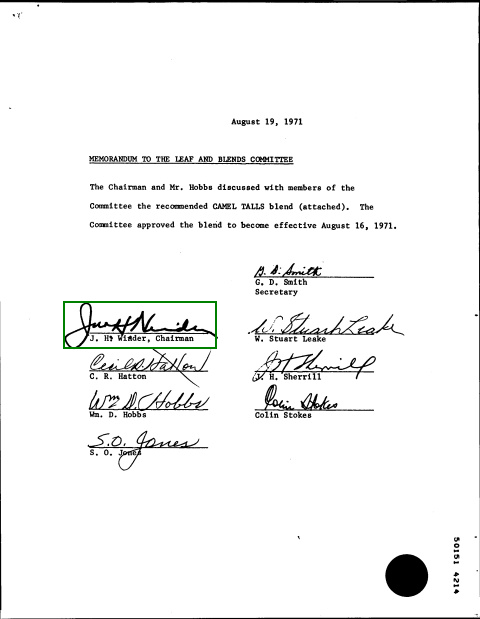

DLSignature (0.786)


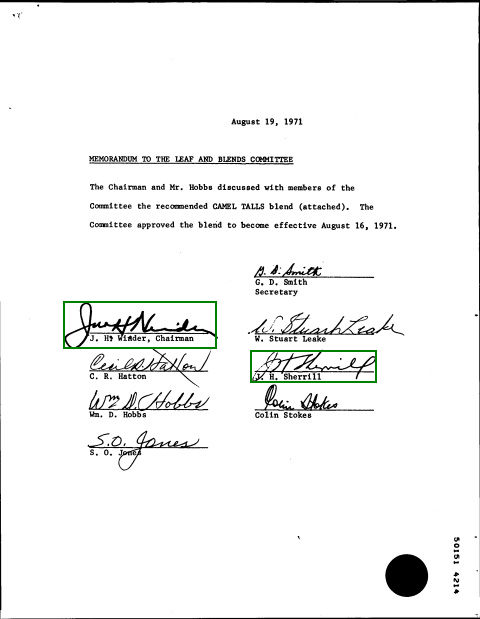

DLSignature (0.773)


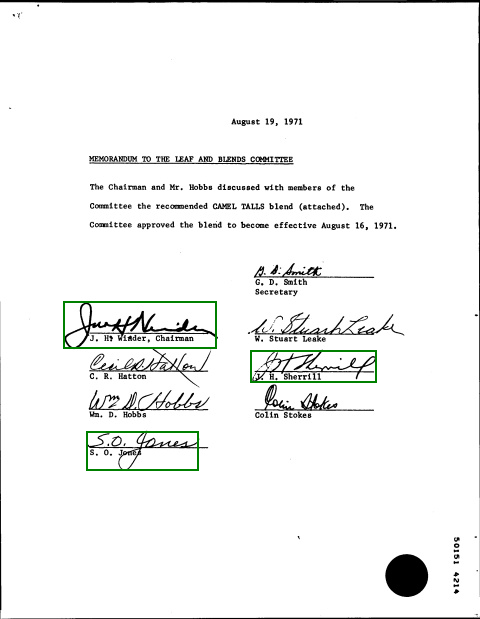

DLSignature (0.745)


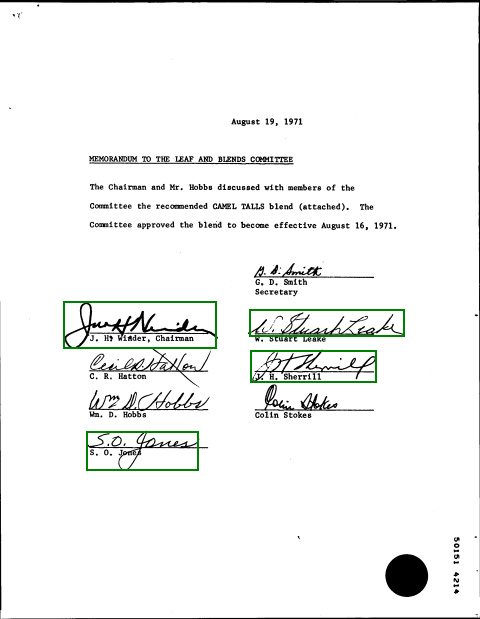

DLSignature (0.632)


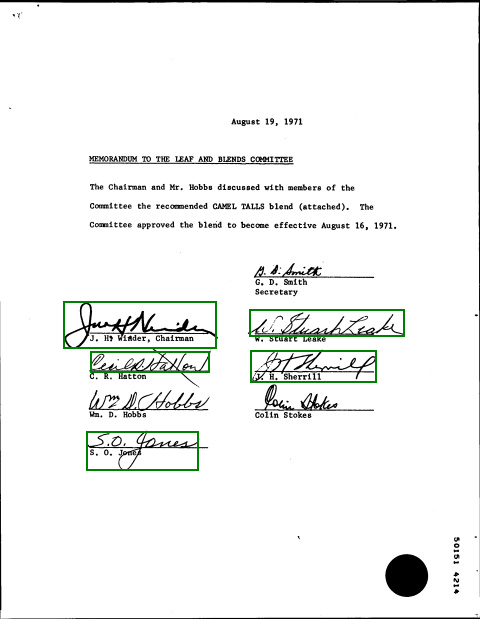

DLSignature (0.630)


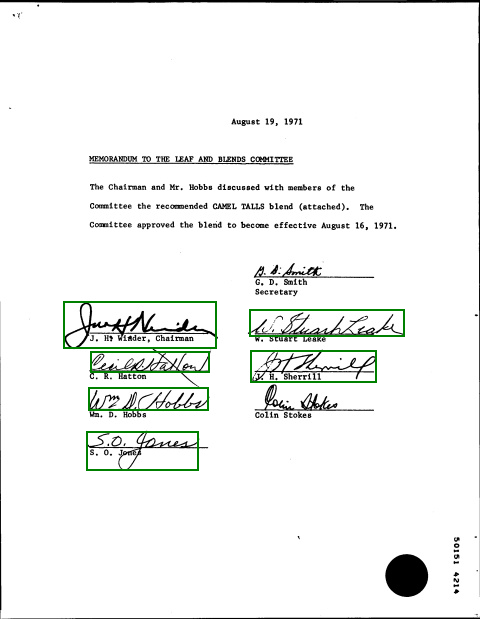

DLSignature (0.545)


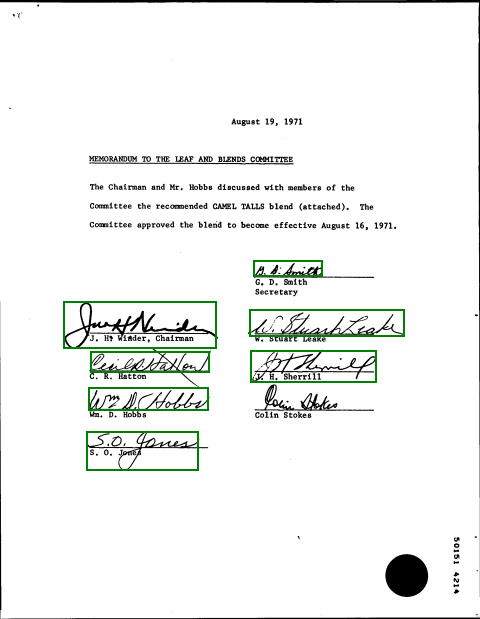

DLSignature (0.515)


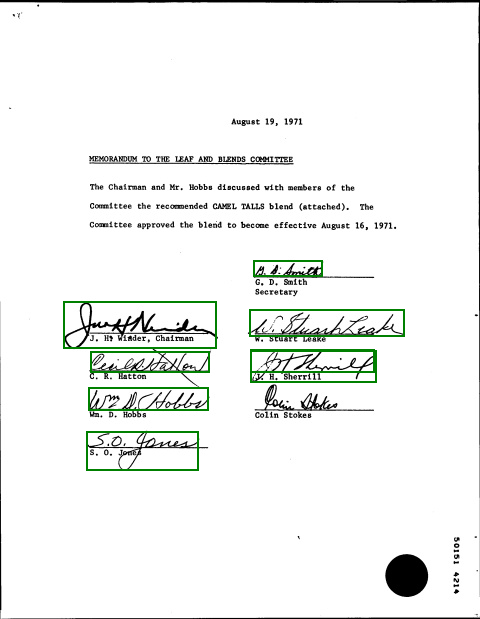

DLSignature (0.506)


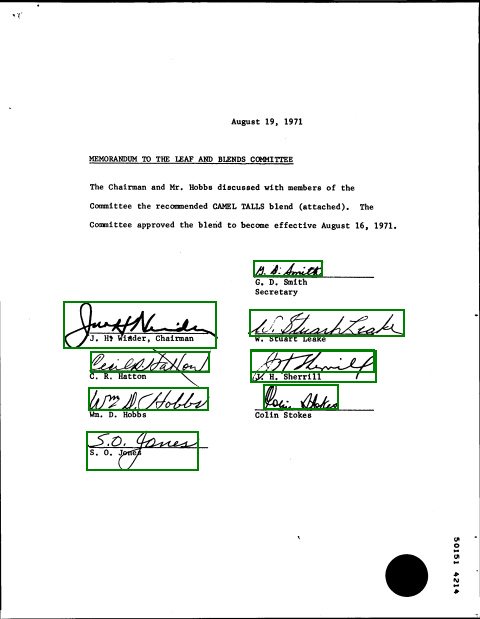

In [61]:
def draw_model_results(image_path, results):
    # Previsões das caixas delimitadoras a partir dos resultados do modelo
    predictions = results[0].boxes.data.tolist()

    # Carrega a imagem
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Labels e suas cores correspondentes
    labels = ["DLLogo", "DLSignature"]
    colors = ["red", "green"]

    # Itera sobre cada caixa delimitadora prevista
    for prediction in predictions:
        x1, y1, x2, y2, confidence, label = prediction

        # Converte a label para inteiro e valida
        label = int(label)
        if label >= len(labels):
            continue

        # Desenha a caixa delimitadora
        draw.rectangle([(x1, y1), (x2, y2)], outline=colors[label], width=2)

        # Texto com label e nível de confiança
        text = f'{labels[label]} ({confidence:.3f})'

        # Imprime o texto com label e nível de confiança
        print(text)

        # Exibe a imagem com as caixas delimitadoras
        display(image)

draw_model_results(test_image, yolo_test_results)